In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.options.mode.chained_assignment = None 
#ENCODING
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
#SCALING
from sklearn.preprocessing import StandardScaler
#Feature Selection:
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
#ML
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xg
#Metrics and Validation:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
## loading the dataset...
cars=pd.read_csv("car_price_prediction.csv")

In [3]:
cars.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

# DATA CLEANING

In [4]:
#number of null values in our dataset
cars.isnull().sum(axis=0)

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [5]:
#dropping duplicates
ncars=cars.drop_duplicates(keep=False)

In [6]:
ncars.head()

ID  Price  Levy Manufacturer     Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS    RX 450        2010       Jeep   
2  45774419   8467     -        HONDA       FIT        2006  Hatchback   
3  45769185   3607   862         FORD    Escape        2011       Jeep   
4  45809263  11726   446        HONDA       FIT        2014  Hatchback   
5  45802912  39493   891      HYUNDAI  Santa FE        2016       Jeep   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   
5              Yes    Diesel             2  160931 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4  
5     Automatic        Front  04-May        Left wheel   White        4

In [7]:
ncars.Levy.dtype

dtype('O')

In [8]:
#In Levy column,hyphens are replaced with zeroes
ncars.Levy=ncars.Levy.str.replace('-','0')

In [9]:
#obj->int
ncars.Levy=ncars.Levy.astype('int64')

In [10]:
ncars.Levy

0        1399
2           0
3         862
4         446
5         891
         ... 
19232       0
19233     831
19234     836
19235    1288
19236     753
Name: Levy, Length: 18704, dtype: int64

In [11]:
#as Mileage is a factor, removing "km" from it helps in improvising the prediction
ncars.Mileage.head()

0    186005 km
2    200000 km
3    168966 km
4     91901 km
5    160931 km
Name: Mileage, dtype: object

In [12]:
#we have to drop the km 
ncars.Mileage=ncars.Mileage.apply(lambda x:str(x).replace("km"," "))
#converting into int
ncars.Mileage=ncars.Mileage.apply(lambda x:int(x))

In [13]:
ncars.Mileage

0        186005
2        200000
3        168966
4         91901
5        160931
          ...  
19232    300000
19233    161600
19234    116365
19235     51258
19236    186923
Name: Mileage, Length: 18704, dtype: int64

In [14]:
#Doors have mixed datatype with both strings and integers
ncars.Doors.head()

0    04-May
2    04-May
3    04-May
4    04-May
5    04-May
Name: Doors, dtype: object

In [15]:
ncars.Doors.unique()

array(['04-May', '02-Mar', '>5'], dtype=object)

In [16]:
#converting the Doors field in more readable form
ncars.Doors=ncars.Doors.str.replace('04-May','4-5').replace('02-Mar','2-3')

In [17]:
ncars.Doors.unique()

array(['4-5', '2-3', '>5'], dtype=object)

In [18]:
ncars['Engine volume']

0              3.5
2              1.3
3              2.5
4              1.3
5                2
           ...    
19232    2.0 Turbo
19233          2.4
19234            2
19235            2
19236          2.4
Name: Engine volume, Length: 18704, dtype: object

In [19]:
#removing "Turbo" from this field
ncars['Engine volume']=ncars['Engine volume'].str.replace(r'([a-z,' ',A-Z])','').astype('f')

C:\Users\abdul\AppData\Local\Temp\ipykernel_12896\1559818505.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ncars['Engine volume']=ncars['Engine volume'].str.replace(r'([a-z,' ',A-Z])','').astype('f')


In [20]:
ncars['Engine volume']

0        3.5
2        1.3
3        2.5
4        1.3
5        2.0
        ... 
19232    2.0
19233    2.4
19234    2.0
19235    2.0
19236    2.4
Name: Engine volume, Length: 18704, dtype: float32

In [21]:
#making the following fields object data type. Why? Because, it doesn't much predict the price of the car imo
ncars['Cylinders']=ncars['Cylinders'].astype('O')
ncars['Airbags']=ncars['Airbags'].astype('O')

In [22]:
ncars.describe()

ID         Price          Levy    Prod. year  Engine volume  \
count  1.870400e+04  1.870400e+04  18704.000000  18704.000000   18704.000000   
mean   4.557522e+07  1.860236e+04    632.444985   2010.906758       2.305778   
std    9.363561e+05  1.932520e+05    569.018150      5.667116       0.877488   
min    2.074688e+07  1.000000e+00      0.000000   1939.000000       0.000000   
25%    4.569182e+07  5.331000e+03      0.000000   2009.000000       1.800000   
50%    4.577164e+07  1.317200e+04    642.000000   2012.000000       2.000000   
75%    4.580162e+07  2.200000e+04    915.000000   2015.000000       2.500000   
max    4.581665e+07  2.630750e+07  11714.000000   2020.000000      20.000000   

            Mileage  
count  1.870400e+04  
mean   1.572059e+06  
std    4.908815e+07  
min    0.000000e+00  
25%    7.030300e+04  
50%    1.266900e+05  
75%    1.895300e+05  
max    2.147484e+09

In [23]:
ncars.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

In [24]:
cat_col = list(cars.select_dtypes('O').columns)
num_col = list(cars.select_dtypes(np.number).columns)

In [25]:
Manufact=ncars.Manufacturer.unique()

In [26]:
ncars.Manufacturer.value_counts().head()

HYUNDAI          3690
TOYOTA           3563
MERCEDES-BENZ    2019
FORD             1075
BMW              1027
Name: Manufacturer, dtype: int64

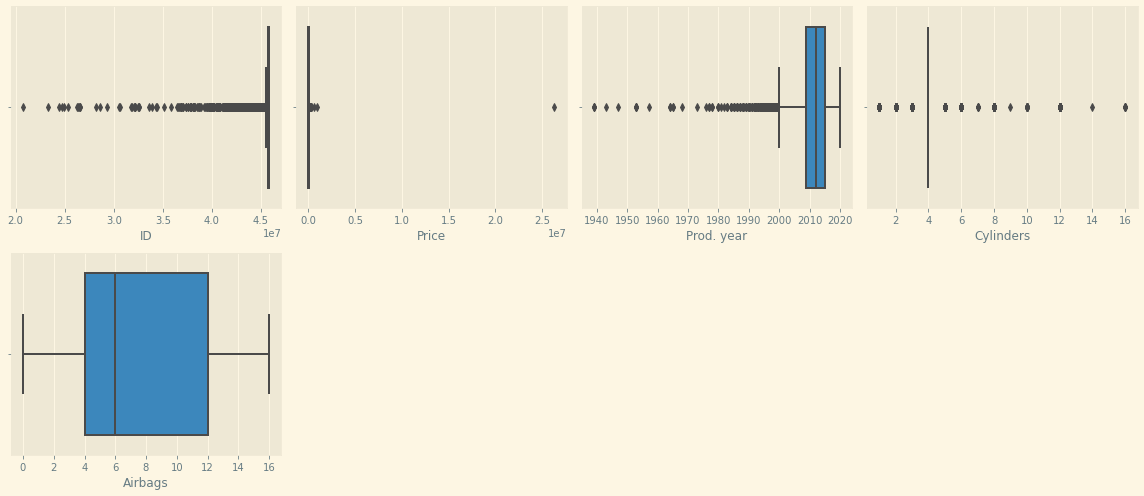

In [27]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=[16,7])
for i,j in enumerate(num_col):
    plt.subplot(2,4,i+1)
    sns.boxplot(x=ncars[j])
    plt.tight_layout()
plt.show()

In [28]:
ccars=ncars.copy()

In [29]:
q1=ccars.quantile(0.25)
q3=ccars.quantile(0.75)
iqr=q3-q1

In [30]:
cat_col = list(ccars.select_dtypes('O').columns)
num_col = list(ccars.select_dtypes(np.number).columns)

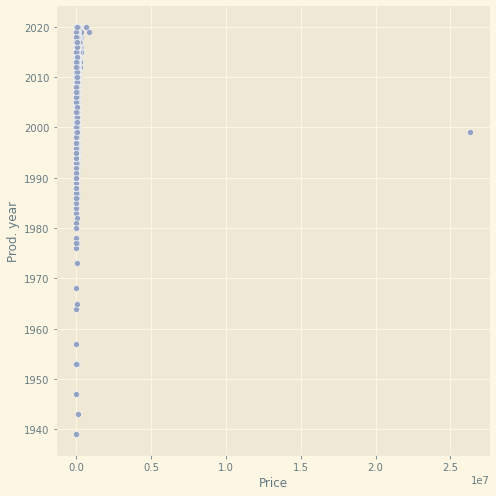

In [31]:
ax = sns.relplot(data=ccars, x="Price", y="Prod. year", color = '#95a3c3', sizes=(100, 200), height=7, marker='o')

In [32]:
(ccars['Prod. year']>2008)

0         True
2        False
3         True
4         True
5         True
         ...  
19232    False
19233     True
19234     True
19235    False
19236     True
Name: Prod. year, Length: 18704, dtype: bool

In [33]:
ccars['NewCar']=ccars['Prod. year']>2008

In [34]:
ccars

ID  Price  Levy   Manufacturer     Model  Prod. year   Category  \
0      45654403  13328  1399          LEXUS    RX 450        2010       Jeep   
2      45774419   8467     0          HONDA       FIT        2006  Hatchback   
3      45769185   3607   862           FORD    Escape        2011       Jeep   
4      45809263  11726   446          HONDA       FIT        2014  Hatchback   
5      45802912  39493   891        HYUNDAI  Santa FE        2016       Jeep   
...         ...    ...   ...            ...       ...         ...        ...   
19232  45798355   8467     0  MERCEDES-BENZ   CLK 200        1999      Coupe   
19233  45778856  15681   831        HYUNDAI    Sonata        2011      Sedan   
19234  45804997  26108   836        HYUNDAI    Tucson        2010       Jeep   
19235  45793526   5331  1288      CHEVROLET   Captiva        2007       Jeep   
19236  45813273    470   753        HYUNDAI    Sonata        2012      Sedan   

      Leather interior Fuel type  Engine volume  Mileage Cylinders  \
0                  Yes    Hybrid            3.5   186005       6.0   
2                   No    Petrol            1.3   200000       4.0   
3                  Yes    Hybrid            2.5   168966       4.0   
4                  Yes    Petrol            1.3    91901       4.0   
5                  Yes    Diesel            2.0   160931       4.0   
...                ...       ...            ...      ...       ...   
19232              Yes       CNG            2.0   300000       4.0   
19233              Yes    Petrol            2.4   161600       4.0   
19234              Yes    Diesel            2.0   116365       4.0   
19235              Yes    Diesel            2.0    51258       4.0   
19236              Yes    Hybrid            2.4   186923       4.0   

      Gear box type Drive wheels Doors             Wheel   Color Airbags  \
0         Automatic          4x4   4-5        Left wheel  Silver      12   
2          Variator        Front   4-5  Right-hand drive   Black       2   
3         Automatic          4x4   4-5        Left wheel   White       0   
4         Automatic        Front   4-5        Left wheel  Silver       4   
5         Automatic        Front   4-5        Left wheel   White       4   
...             ...          ...   ...               ...     ...     ...   
19232        Manual         Rear   2-3        Left wheel  Silver       5   
19233     Tiptronic        Front   4-5        Left wheel     Red       8   
19234     Automatic        Front   4-5        Left wheel    Grey       4   
19235     Automatic        Front   4-5        Left wheel   Black       4   
19236     Automatic        Front   4-5        Left wheel   White      12   

       NewCar  
0        True  
2       False  
3        True  
4        True  
5        True  
...       ...  
19232   False  
19233    True  
19234    True  
19235   False  
19236    True  

[18704 rows x 19 columns]

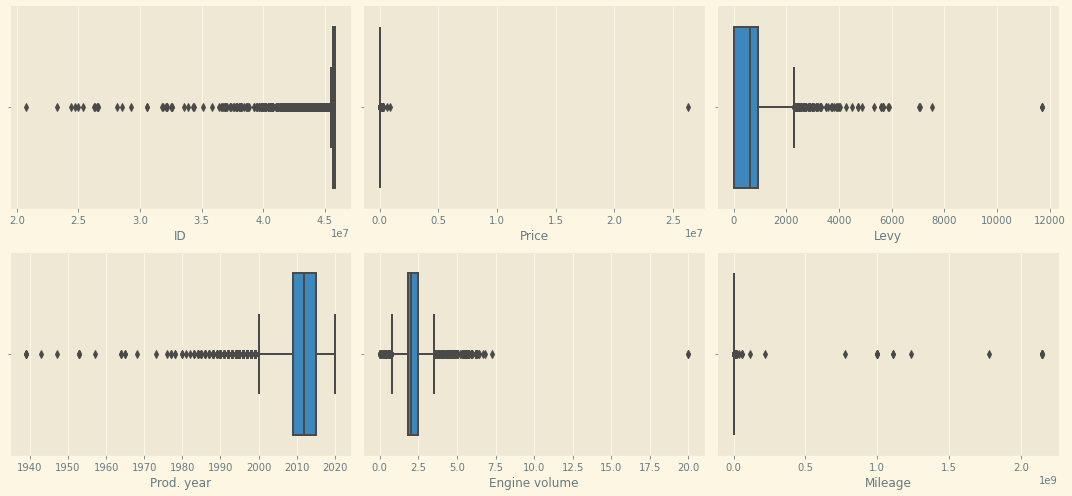

In [35]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=[15,7])
for i,j in enumerate(num_col):
    plt.subplot(2,3,i+1)
    sns.boxplot(x=ccars[j])
    plt.tight_layout()
plt.show()

In [36]:
#Does ID is necessary for us to predict the price? No! So we are free to drop it from numerical columns
num_col.remove('ID')
ccars.drop(columns='ID',inplace=True)

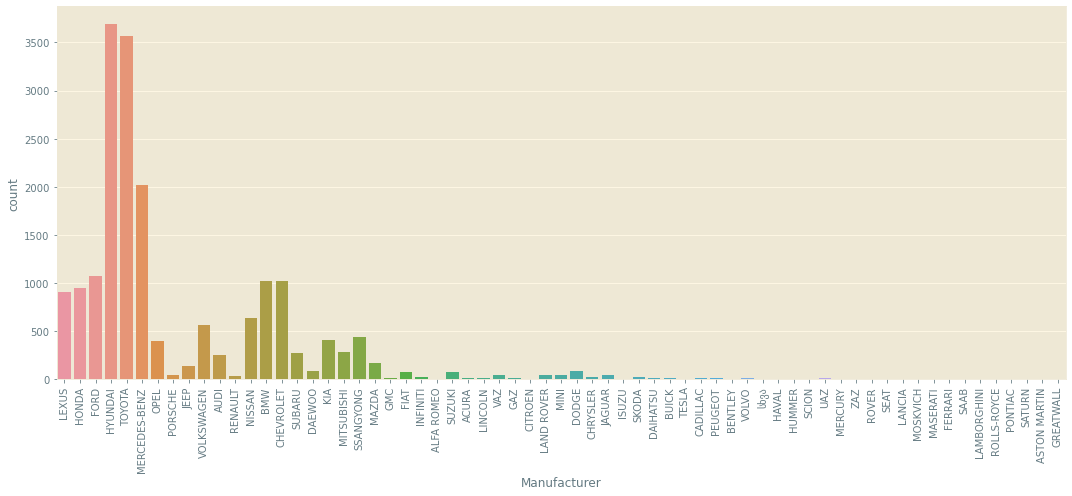

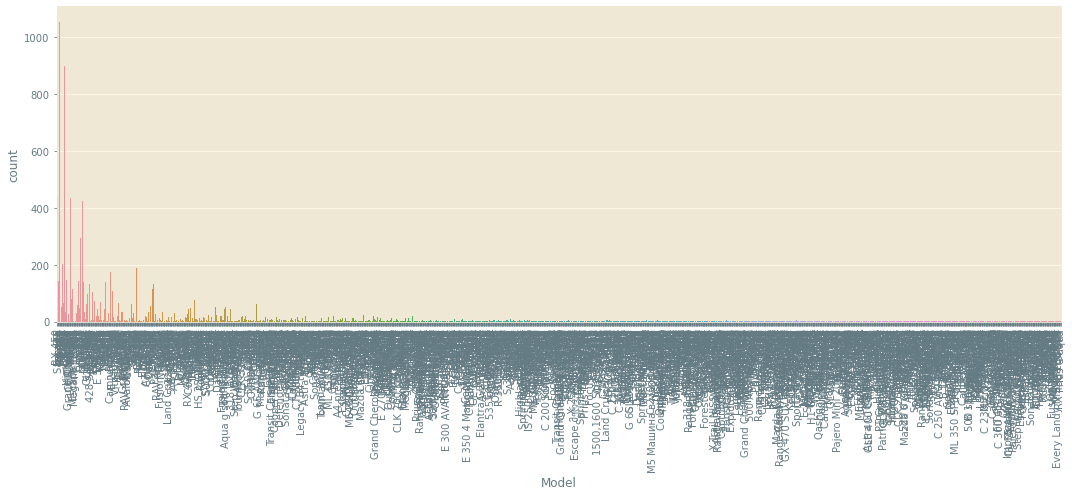

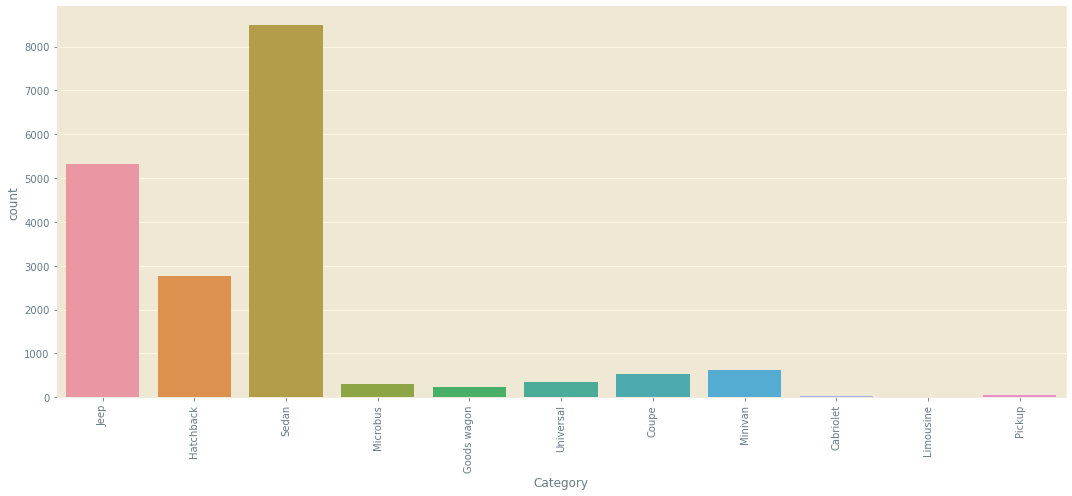

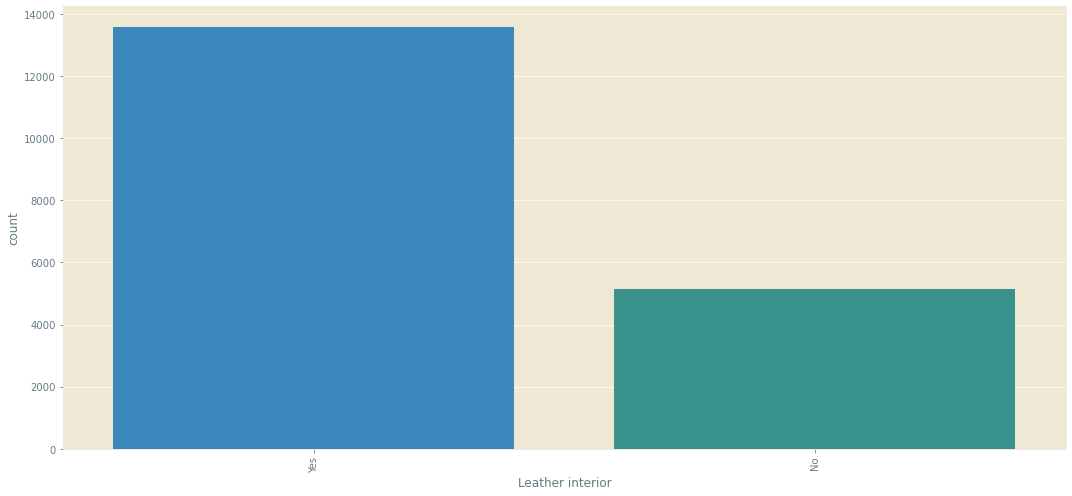

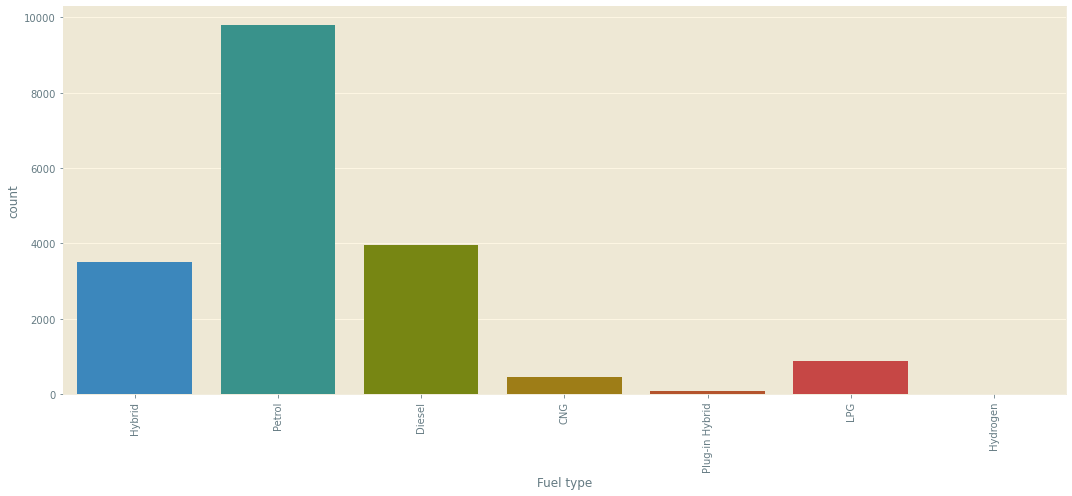

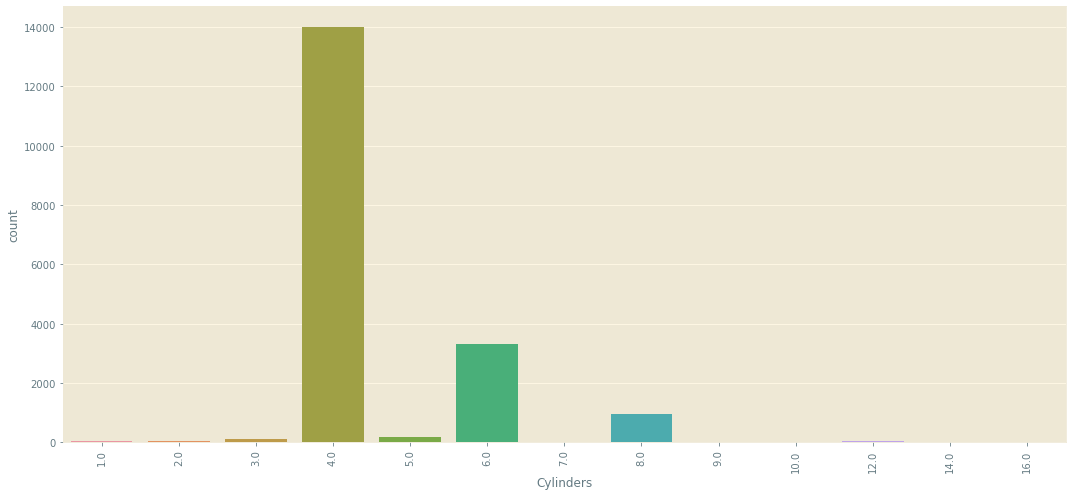

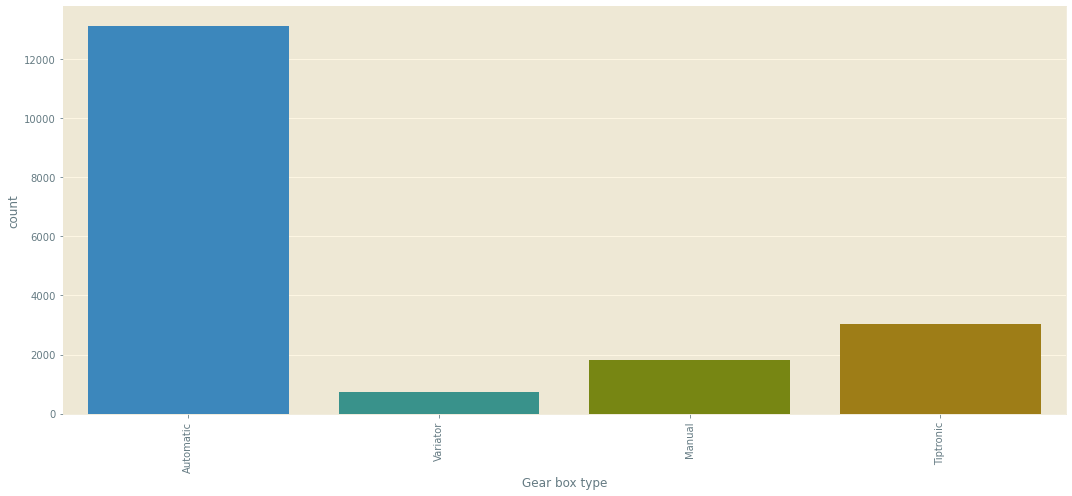

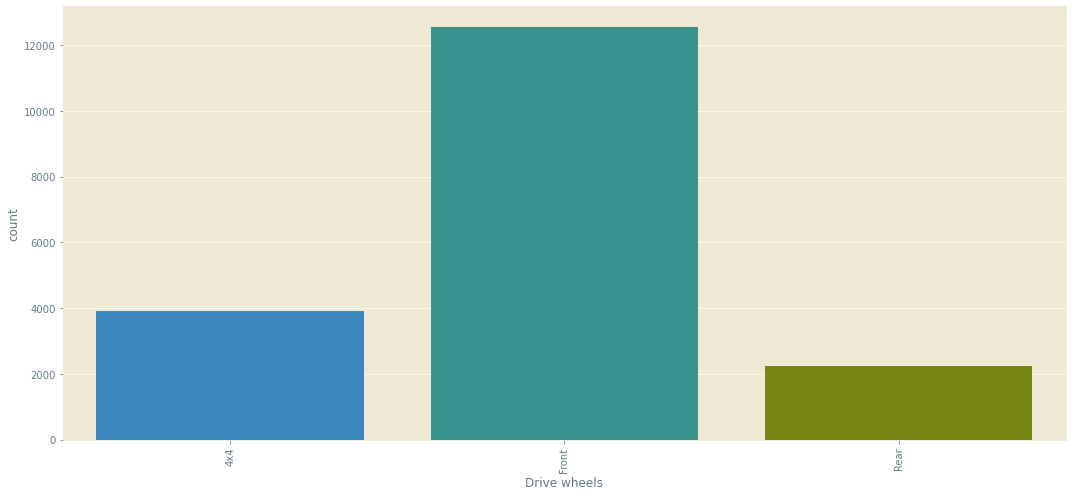

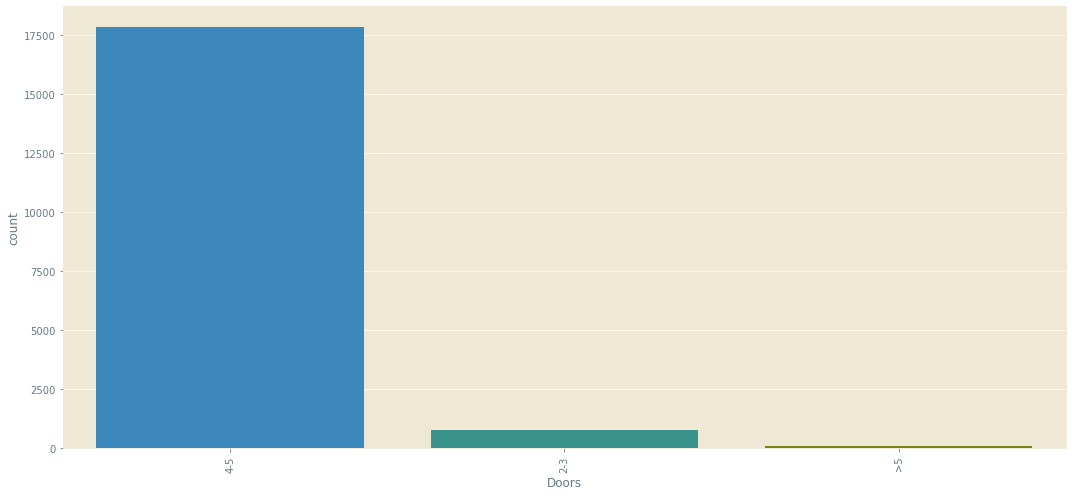

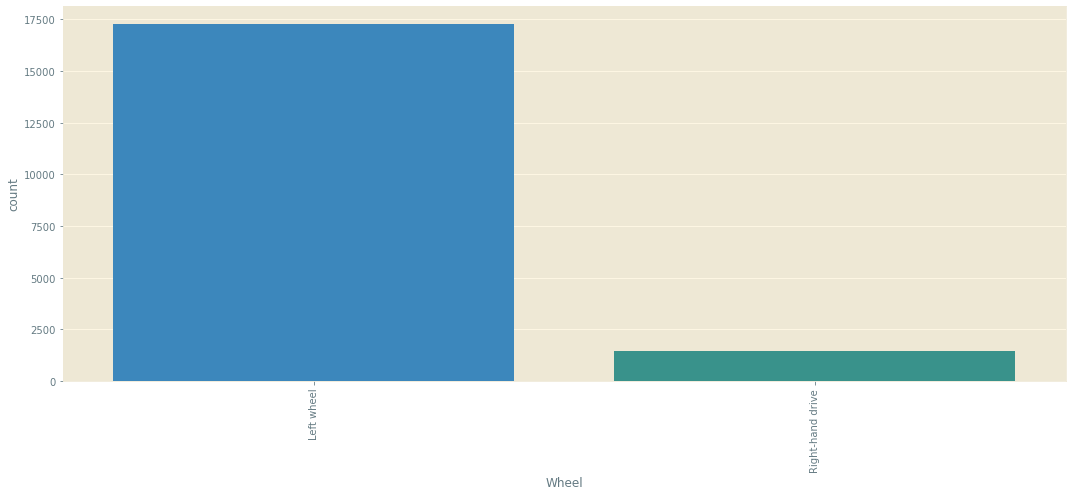

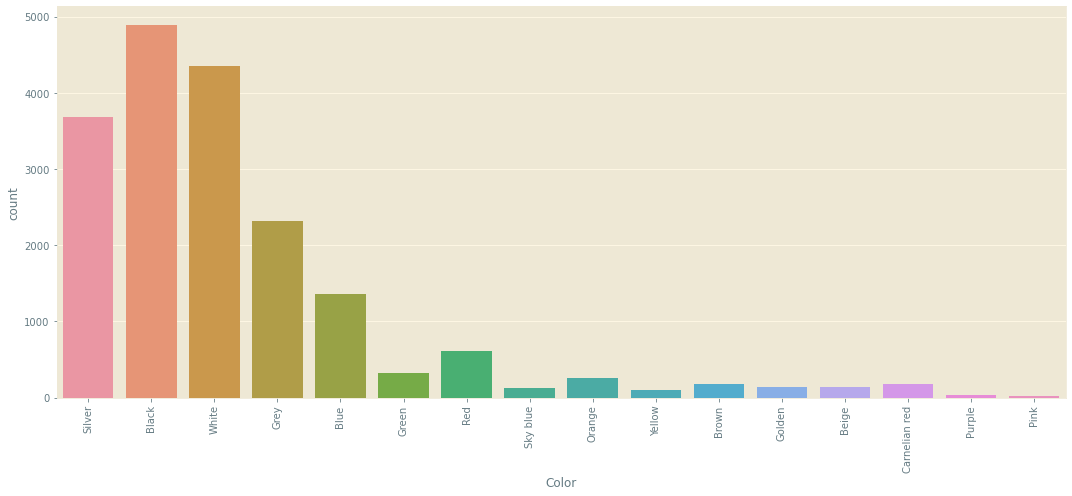

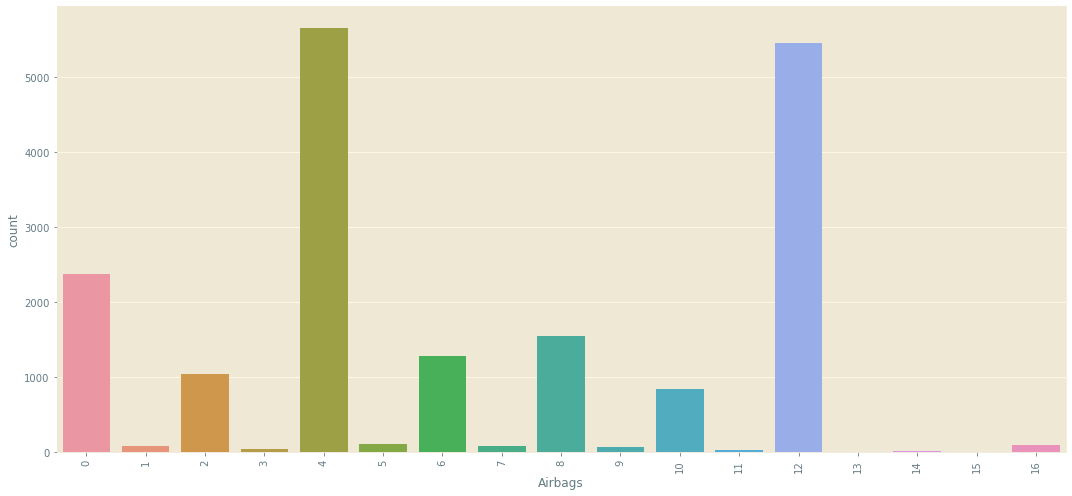

In [37]:
%matplotlib inline
for i in cat_col:
        plt.figure(figsize=[15,7])
        sns.countplot(x=ccars[i])
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [38]:
#To get an overview of which Category are preferred by each manufacturer
fig = px.treemap(data_frame=ccars,path=["Manufacturer","Category","Model"],title='MANUFACTURER WISE DATA DISTRIBUTION')
fig.show()

C:\Users\abdul\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
C:\Users\abdul\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
C:\Users\abdul\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)


In [39]:
fig = px.treemap(data_frame=ccars,path=["Manufacturer","Category","Model"],values='Price',title='MANUFACTURER WISE TOTAL PRICE | SALES DISTRIBUTION')
fig.show()

C:\Users\abdul\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\abdul\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\abdul\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [40]:
#Insights:
#Brandwise Hyundai is the leading brand followed by Toyota and Mercedes Benz
#Among cars, Jeep and Sedan type cars are most preferred by customers
#Most customers wish to have leather interior for their cars
#Cars with four cylinders is favourable by the customers 
#Most preferred fuel type:Petrol
#Cars with left wheel are in higher demand
#Most preferred drive wheel:front
#Most preferred Gear type:Automatic
#Most preferred Color:Silver,White,Grey,Black

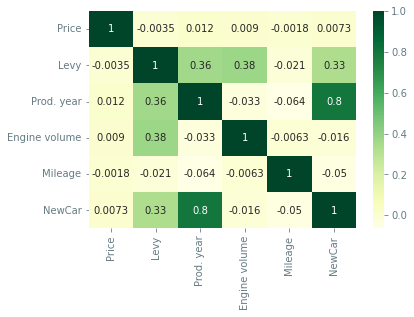

In [41]:
sns.heatmap(data=ccars.corr(),cmap='YlGn',annot=True)
plt.show()

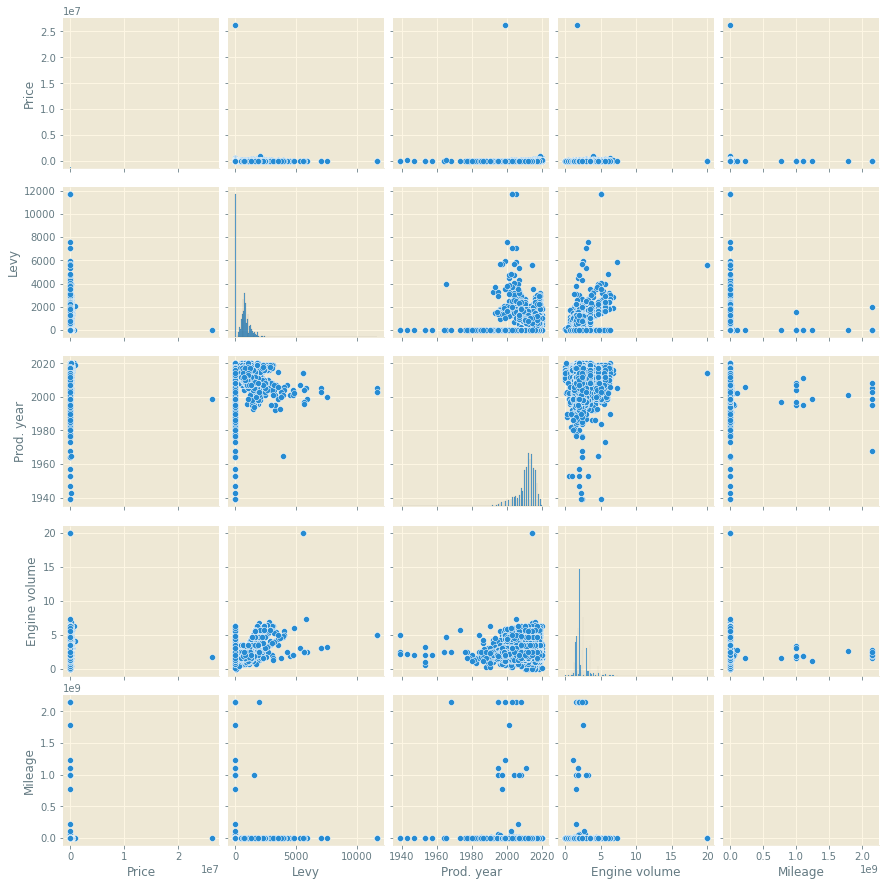

In [42]:
sns.pairplot(ccars[num_col])
plt.show()

In [43]:
len(cars.Model.unique())

1590

In [44]:
#Train-Test-Split
X=ccars.copy()
X.drop(columns='Price',inplace=True)
y=ccars['Price']

In [45]:
X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=1,test_size=0.3)

# Encoding

In [46]:
#Making production years are unique categorical values
yrs = list(X['Prod. year'].sort_values().unique())
mapuni = {j:i for i,j in enumerate(yrs)}

In [47]:
#We are going to use three types of encoding in our dataset:Ordinal,Binary Encoded,Binary
#Fields like 'Manufacturer','Category' are having categorical values. So, it is Binary encoded.
#Fields like 'Year' are kept ordinal in our dataset
#Some fields like 'Leather interior','Wheel' have binary variables like Yes/No - we can make it binary [eg:Yes:1 No:0]
#Fields like 'Cylinders','Airbags' are considered as it is

In [48]:
#Binary encoding our categorical variables;drop_invariant is set to False because it leads to loss of accuracy in our prediction
ec = ce.BinaryEncoder(cols=['Manufacturer','Model','Category','Fuel type','Gear box type','Drive wheels','Color'],drop_invariant=False,return_df=True)
X_train_ec = ec.fit_transform(X=X_train)
X_test_ec = ec.transform(X=X_test)

In [49]:
#Binary Encoding the categorical variables
X_train_ec['Prod. year'] = X_train_ec['Prod. year'].replace(mapuni)
X_test_ec['Prod. year'] = X_test_ec['Prod. year'].replace(mapuni)
X_train_ec['Doors'] = X_train_ec['Doors'].replace({'2-3':0,'4-5':1,'>5':2})
X_test_ec['Doors'] = X_test_ec['Doors'].replace({'2-3':0,'4-5':1,'>5':2})
X_train_ec['Leather interior'] = X_train_ec['Leather interior'].replace({'Yes':1,'No':0})
X_test_ec['Leather interior'] = X_test_ec['Leather interior'].replace({'Yes':1,'No':0})
X_train_ec['Wheel'] = X_train_ec['Wheel'].replace({'Left wheel':1,'Right-hand drive':0})
X_test_ec['Wheel'] = X_test_ec['Wheel'].replace({'Left wheel':1,'Right-hand drive':0})
X_train_ec['NewCar'] = X_train_ec['NewCar'].replace({True:1,False:0})
X_test_ec['NewCar'] = X_test_ec['NewCar'].replace({True:1,False:0})

In [50]:
X_train_ec['Cylinders'],X_train_ec['Airbags'] = X_train_ec['Cylinders'].astype('i'),X_train_ec['Airbags'].astype('i')
X_test_ec['Cylinders'],X_test_ec['Airbags'] = X_test_ec['Cylinders'].astype('i'),X_test_ec['Airbags'].astype('i')

# Machine Learning Models Building & Evaluation 

## Base XGBRegressor 

In [51]:
baseXGB = xg.XGBRegressor(n_estimators=100,booster='gbtree',random_state=10)
baseXGB.fit(X_train_ec,y_train)
y_train_pre_baseXGB = baseXGB.predict(X_train_ec)
y_test_pre_baseXGB = baseXGB.predict(X_test_ec)
Train_rsq_baseXGB = r2_score(y_train,y_train_pre_baseXGB)
print("Train R-square associated with Base XG Boost Regression is : ", Train_rsq_baseXGB,'\n')
Test_rsq_baseXGB = r2_score(y_test , y_test_pre_baseXGB)
print("Test R-square associated with Base XG Boost Regression is : ", Test_rsq_baseXGB,'\n')
print("Test RMS_error:", np.sqrt(mean_squared_error(y_test , y_test_pre_baseXGB)),'\n')
print("Test Mean absolute error: ",mean_absolute_error(y_test , y_test_pre_baseXGB),'\n')
print("Test Mean absolute percentage error: ", mean_absolute_percentage_error(y_test , y_test_pre_baseXGB),'\n')
cv_score_baseXGB = cross_val_score(baseXGB,X_test_ec,y_test,cv=15,scoring='r2')
print('Test Scores:',cv_score_baseXGB)
print('Score Mean',cv_score_baseXGB.mean()*100, 'Score Standard Deviation', cv_score_baseXGB.std()*100)

Train R-square associated with Base XG Boost Regression is :  0.9994613840816686 

Test R-square associated with Base XG Boost Regression is :  -1451.2558228983316 

Test RMS_error: 694612.525177229 

Test Mean absolute error:  23829.890762131126 

Test Mean absolute percentage error:  17.779288918976466 

Test Scores: [0.61879112 0.64729538 0.59261167 0.69814087 0.72502202 0.56108858
 0.6629294  0.69940083 0.75961398 0.62133567 0.61215458 0.69102911
 0.63698527 0.6657251  0.65584045]
Score Mean 65.65309336871704 Score Standard Deviation 5.066026519016277


## Random Forest Regressor 

In [52]:
baseRFR = RandomForestRegressor(n_estimators=100, random_state=10)
baseRFR.fit(X_train_ec, y_train)
y_train_pre_baseRFR = baseRFR.predict(X_train_ec)
y_test_pre_baseRFR = baseRFR.predict(X_test_ec)
Train_rsq_baseRFR = r2_score(y_train, y_train_pre_baseRFR)
print("Train R-square associated with Base Random Forest Regression is : ", Train_rsq_baseRFR,'\n')
Test_rsq_baseRFR = r2_score(y_test , y_test_pre_baseRFR)
print("Test R-square associated with Base Random Forest Regression is : ", Test_rsq_baseRFR,'\n')
print("Test RMS_error:", np.sqrt(mean_squared_error(y_test , y_test_pre_baseRFR)),'\n')
print("Test Mean absolute error: ",mean_absolute_error(y_test , y_test_pre_baseRFR),'\n')
print("Test Mean absolute percentage error: ", mean_absolute_percentage_error(y_test , y_test_pre_baseRFR),'\n')
cv_score_baseRFR = cross_val_score(baseRFR, X_test_ec, y_test, cv=15, scoring='r2')
print('Test Scores:',cv_score_baseRFR)
print('Score Mean',cv_score_baseRFR.mean()*100, 'Score Standard Deviation', cv_score_baseRFR.std()*100)

Train R-square associated with Base Random Forest Regression is :  0.7902173452595027 

Test R-square associated with Base Random Forest Regression is :  -218.87422975321084 

Test RMS_error: 270276.4540663449 

Test Mean absolute error:  14050.551072226854 

Test Mean absolute percentage error:  18.291713890742702 

Test Scores: [0.66411069 0.69522758 0.61685588 0.66135819 0.70063388 0.60291909
 0.70936467 0.61886861 0.75658123 0.66664551 0.66132889 0.69284323
 0.7077254  0.64655677 0.63992576]
Score Mean 66.93963589414658 Score Standard Deviation 4.012374171540704


## Ada Boost Regressor 

In [53]:
baseABR = AdaBoostRegressor(n_estimators=100, random_state=10)
baseABR.fit(X_train_ec, y_train)
y_train_pre_baseABR = baseABR.predict(X_train_ec)
y_test_pre_baseABR = baseABR.predict(X_test_ec)
Train_rsq_baseABR = r2_score(y_train, y_train_pre_baseABR)
print("Train R-square associated with Base Ada Boost Regression is : ", Train_rsq_baseABR,'\n')
Test_rsq_baseABR = r2_score(y_test , y_test_pre_baseABR)
print("Test R-square associated with Base Ada Boost Regression is : ", Test_rsq_baseABR,'\n')
print("Test RMS_error:", np.sqrt(mean_squared_error(y_test , y_test_pre_baseABR)),'\n')
print("Test Mean absolute error: ",mean_absolute_error(y_test , y_test_pre_baseABR),'\n')
print("Test Mean absolute percentage error: ", mean_absolute_percentage_error(y_test , y_test_pre_baseABR),'\n')
cv_score_baseABR = cross_val_score(baseABR, X_test_ec, y_test, cv=15, scoring='r2')
print('Test Scores:',cv_score_baseABR)
print('Score Mean',cv_score_baseABR.mean()*100, 'Score Standard Deviation', cv_score_baseABR.std()*100)

Train R-square associated with Base Ada Boost Regression is :  0.9936109174664701 

Test R-square associated with Base Ada Boost Regression is :  -0.04862946863370765 

Test RMS_error: 18665.17542528438 

Test Mean absolute error:  13543.788805165628 

Test Mean absolute percentage error:  28.69510539512158 

Test Scores: [-0.66853364 -0.69930725 -0.32950805 -0.77124252 -1.28107816  0.06909262
 -0.80914716 -0.91306038 -0.52159777 -0.62518575 -1.47107509 -0.54131343
 -0.8264356  -0.37088976 -1.20837862]
Score Mean -73.11773709457387 Score Standard Deviation 37.90447777413593


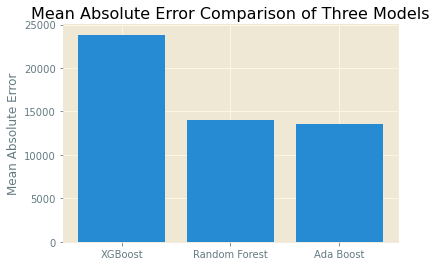

In [54]:
xgb_mae = 23829.890762131126
rf_mae = 14050.551072226854
ada_mae = 13543.788805165628

models = ['XGBoost', 'Random Forest', 'Ada Boost']
mae = [xgb_mae, rf_mae, ada_mae]

x_pos = np.arange(len(models))

plt.bar(x_pos, mae, align='center')
plt.xticks(x_pos, models)
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Comparison of Three Models')

plt.show()

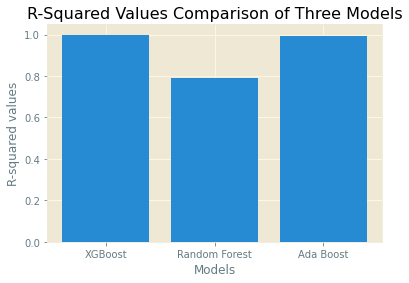

In [55]:
xgb_rsquared = 0.9994613840816686
rf_rsquared = 0.7902173452595027
ada_rsquared = 0.9936109174664701

model_names = ['XGBoost', 'Random Forest', 'Ada Boost']
rsquared_values = [xgb_rsquared, rf_rsquared, ada_rsquared]

plt.bar(model_names, rsquared_values)
plt.xlabel('Models')
plt.ylabel('R-squared values')
plt.title('R-Squared Values Comparison of Three Models')
plt.show()